In [2]:
import pandas as pd
import difflib
import datetime
import dateutil
import xgboost
import category_encoders as ce
import scipy.stats as stats
import numpy as np

from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


import json
import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
from carly import outlier_detection

In [4]:
# Load the autoreload extension
%load_ext autoreload

# Set autoreload to automatically reload modules before executing code
%autoreload 2


In [5]:
train_df_RAW = pd.read_csv("../dataset/train.csv")
test_df_RAW = pd.read_csv("../dataset/test.csv")

combined_df = pd.concat([train_df_RAW, test_df_RAW], ignore_index=True)

In [6]:
# GLOBAL VARIABLES
IMPUTERS = {}

# Create mapping for fuel type from model make
fuel_type_mapping = combined_df.groupby(['make', 'model'])['fuel_type'].agg(lambda x: x.mode()[0] if not x.mode().empty else None).reset_index()
FUEL_TYPE_DICT = dict(zip(zip(fuel_type_mapping['make'], fuel_type_mapping['model']), fuel_type_mapping['fuel_type']))


In [7]:
def DEDUP_listingid(df):
    
    df['listing_id']    = df['listing_id'].astype(int).astype(str).str.strip()
    df                  = df.drop_duplicates('listing_id')

    return (df)
    
def FIXNULL_make(df): 

    df['make']          = df['make'].str.upper()
    df['make']          = df['make'].str.replace(' ','').str.strip()
    df['title']         = df['title'].str.upper()
    
    make_list           = [make for make in df['make'].unique().tolist() if type(make) == str]
    df['make_temp']     = df['title'].str.split(' ').str[0]
    df['make_temp']     = df.apply(lambda x: difflib.get_close_matches(x['make_temp'], make_list, n=1)[0], axis=1)
    df['make']          = df['make'].fillna(df['make_temp'])
    df                  = df.drop(columns = 'make_temp')

    return (df)

def FIXNULL_manufacture(df):

    df['original_reg_date']         = pd.to_datetime(df['original_reg_date'], format = "%d-%b-%Y")
    df['reg_date']                  = pd.to_datetime(df['reg_date'], format = "%d-%b-%Y")
    
    df['original_reg_date_temp']    = df['original_reg_date'].dt.year
    df['reg_date_temp']             = df['reg_date'].dt.year
    df['manufactured']              = df['manufactured'].fillna(df[['original_reg_date_temp','reg_date_temp']].min(axis=1))
    df['manufactured']              = df['manufactured'].astype(int).astype(str)
    df                              = df.drop(columns = ['original_reg_date_temp', 'reg_date_temp'])
    
    return (df)

def FIXNULL_ownercount(df):
    
    # df['no_of_owners'] = df['no_of_owners'].fillna(1)
    df['no_of_owners'] = df['no_of_owners'].fillna(df['no_of_owners'].median())
    
    return df

def FIXNULL_dereg(df):
    df['dereg_value'] = df['dereg_value'].fillna(0)
    return(df)

def FIXNULL_fueltype(df):
    # Extract fuel type from category
    fuel_keywords = {
        'electric': 'electric',
        'hybrid': 'petrol-electric'
    }

    def extract_fuel_type(category_text):
        category_text = category_text.lower()  
        for keyword, fuel_type in fuel_keywords.items():
            if keyword in category_text:
                return fuel_type
        return None
    
    df['fuel_type_category_fill'] = df['fuel_type']

    df.loc[df['fuel_type'].isna(), 'fuel_type_category_fill'] = df['category'].apply(extract_fuel_type)

    # Define a function to fill missing fuel types
    def fill_fuel_type(row):
        if pd.isna(row['fuel_type']):
            return FUEL_TYPE_DICT.get((row['make'], row['model']), None)
        return row['fuel_type']

    # Apply the function to fill in missing values
    df['fuel_type_model_make_fill'] = df['fuel_type']
    df.loc[df['fuel_type'].isna(), 'fuel_type_model_make_fill']  = df.apply(fill_fuel_type, axis=1)

    df['fuel_type'] = df['fuel_type_model_make_fill']
    df = df.drop(columns=['fuel_type_model_make_fill', 'fuel_type_category_fill'])

    return df


def ENCODE_category(df, drop = True):
    
    df_temp             = df['category'].str.split(',', expand = True)
    df_temp             = df_temp.astype(str)
    category_set        = set(sum(df['category'].str.split(',').tolist(), []))
    category_set        = set([category.strip() for category in category_set if len(category.strip()) > 1])
    category_dflist     = [df_temp.apply(lambda x: sum(x.str.contains(category)), axis=1).rename(f"CAT-{category.replace(' ','')}") for category in category_set]
    df                  = pd.concat([df]+category_dflist, axis = 1)
    df                  = df.drop(columns = ['category'])

    df['CAT-coeparf'] = df['CAT-coecar'].astype(str).str.replace('1','COE').str.replace('0', 'PARF')
    df['CAT-elechybrid'] = df['CAT-hybridcars'].astype(str).str.replace('1','HYBRID').str.replace('0', 'ELEC')

    if drop == True:
        df = df.drop(columns = ['CAT-electriccars','CAT-hybridcars','CAT-coecar', 'CAT-parfcar',])
        
    return (df)

def ENCODE_transmission(df, drop=True):
    
    df['TRANSMISSION-manual'] = pd.get_dummies(df['transmission'], drop_first=True, dtype=int)
    
    if drop == True:
        df              = df.drop(columns = ['transmission'])
    
    return (df)

def ENCODE_vehtype(df, drop=True):

    df['type_of_vehicle'] = df['type_of_vehicle'].str.upper().str.strip().str.replace(' ','')
    encoder             = ce.BinaryEncoder(cols='type_of_vehicle',return_df=True)
    df_temp             = encoder.fit_transform(df['type_of_vehicle']) 
    df_temp.columns     = [col.replace('type_of_vehicle_', "TYPE-binenc") for col in df_temp.columns] 

    df                  = pd.concat([df, df_temp], axis = 1)

    if drop == True:
        df                  = df.drop(columns = 'type_of_vehicle')

    return df

def ENCODE_make(df, drop=True):

    encoder             = ce.BinaryEncoder(cols='make',return_df=True)
    df_temp             = encoder.fit_transform(df['make']) 
    df_temp.columns     = [col.replace('make_', "MAKE-binenc") for col in df_temp.columns] 

    df = pd.concat([df, df_temp], axis =1)

    if drop==True:
        df = df.drop(columns = ['make'])
    
    return(df)

def ENCODE_opcscheme(df): 
    df.loc[~(df['opc_scheme'].isnull()),'opc_scheme'] = 1
    df['opc_scheme'] = df['opc_scheme'].fillna(0)

    return df

def ENCODE_fueltype(df, drop=True):

    df['fuel_type'] = df['fuel_type'].fillna('unknown').str.upper().str.strip()
    encoder         = ce.BinaryEncoder(cols='fuel_type',return_df=True)
    df_temp         = encoder.fit_transform(df['fuel_type']) 
    df_temp.columns = [col.replace('fuel_type_', "FUEL-binenc") for col in df_temp.columns] 

    df = pd.concat([df, df_temp], axis = 1)

    if drop==True:
        df = df.drop(columns = 'fuel_type')

    return df

def ENCODE_model(df, drop=True):

    df['model']     = df['model'].str.upper()
    
    encoder         = ce.BinaryEncoder(cols='model',return_df=True)
    df_temp         = encoder.fit_transform(df['model']) 
    df_temp.columns = [col.replace('model_', "MODEL-binenc") for col in df_temp.columns] 
    df              = pd.concat([df, df_temp], axis = 1)

    if drop==True:
        df = df.drop(columns = 'model')

    return df

def EXTRACT_features(df):

    df['features'] = df['features'].astype(str).str.upper()
    
    df.loc[(df['features'].str.contains('4 CYLINDER')) | (df['features'].str.contains('4-CYLINDER')) | (df['features'].str.contains('FOUR CYLINDER')), 'FEAT-CYLcount'] = 4
    df.loc[(df['features'].str.contains('5 CYLINDER')) | (df['features'].str.contains('5-CYLINDER')) | (df['features'].str.contains('FIVE CYLINDER')), 'FEAT-CYLcount'] = 5
    df.loc[(df['features'].str.contains('6 CYLINDER')) | (df['features'].str.contains('6-CYLINDER')) | (df['features'].str.contains('SIX CYLINDER')), 'FEAT-CYLcount'] = 6
    df['FEAT-CYLcount'] = df['FEAT-CYLcount'].fillna(0).astype(int)
    
    df['FEAT-brakehp'] = df['features'].str.extract('(\d+)(?:BHP| BHP)') 
    df['FEAT-torque'] = df['features'].str.extract('(\d+)(?:NM| NM)') 
    df['FEAT-valve'] = df['features'].str.extract('(\d+)(?:VALVE| VALVE)') 

    df.loc[(df['features'].str.contains('TURBOCHARGED')) | (df['features'].str.contains('SUPERCHARGED')), 'FEAT-charged_engine'] = 1
    df['FEAT-charged_engine'] = df['FEAT-charged_engine'].fillna(0).astype(int)
    
    df.loc[df['features'].str.contains('SRS'), 'FEAT-srs_airbag'] = 1
    df['FEAT-srs_airbag'] = df['FEAT-srs_airbag'].fillna(0).astype(int)
    df.loc[df['features'].str.contains('KEYLESS'), 'FEAT-keyless_ss'] = 1
    df['FEAT-keyless_ss'] = df['FEAT-keyless_ss'].fillna(0).astype(int)
    df.loc[df['features'].str.contains('GUARANTEE'), 'FEAT-guarantee'] = 1
    df['FEAT-guarantee'] = df['FEAT-guarantee'].fillna(0).astype(int)
    
    df.loc[df['features'].str.contains('AWD'), 'FEAT-awd'] = 1
    df['FEAT-awd'] = df['FEAT-awd'].fillna(0).astype(int)
    df.loc[df['features'].str.contains('4WD'), 'FEAT-4wd'] = 1
    df['FEAT-4wd'] = df['FEAT-4wd'].fillna(0).astype(int)
    df.loc[df['features'].str.contains('RWD'), 'FEAT-rwd'] = 1
    df['FEAT-rwd'] = df['FEAT-rwd'].fillna(0).astype(int)
    df.loc[df['features'].str.contains('FWD'), 'FEAT-fwd'] = 1
    df['FEAT-fwd'] = df['FEAT-fwd'].fillna(0).astype(int)
    
    df = df.drop(columns = 'features')
    
    return df

def EXTRACT_desc(df): 
    df['description'] = df['description'].astype(str).str.upper()

    df.loc[df['description'].str.contains('LOAN'), 'DESC-loan'] = 1
    df['DESC-loan'] = df['DESC-loan'].fillna(0).astype(int)

    df.loc[df['description'].str.contains('MAINTAINED'), 'DESC-maintained'] = 1
    df['DESC-maintained'] = df['DESC-maintained'].fillna(0).astype(int)

    df.loc[df['description'].str.contains('ACCIDENT FREE'), 'DESC-accifree'] = 1
    df['DESC-accifree'] = df['DESC-accifree'].fillna(0).astype(int)

    df.loc[df['description'].str.contains('WARRANTY'), 'DESC-warranty'] = 1
    df['DESC-warranty'] = df['DESC-warranty'].fillna(0).astype(int)

    df.loc[df['description'].str.contains('TRADE IN'), 'DESC-tradein'] = 1
    df['DESC-tradein'] = df['DESC-tradein'].fillna(0).astype(int)

    df = df.drop(columns = 'description')

    return df

def EXTRACT_accessories(df): 
    df['accessories'] = df['accessories'].astype(str).str.upper()

    df.loc[df['accessories'].str.contains('INSPECTION'), 'ACCESS-inspection'] = 1
    df['ACCESS-inspection'] = df['ACCESS-inspection'].fillna(0).astype(int)

    df.loc[df['accessories'].str.contains('AUDIO'), 'ACCESS-audio'] = 1
    df['ACCESS-audio'] = df['ACCESS-audio'].fillna(0).astype(int)

    df.loc[df['accessories'].str.contains('CAMERA'), 'ACCESS-camera'] = 1
    df['ACCESS-camera'] = df['ACCESS-camera'].fillna(0).astype(int)

    df.loc[(df['accessories'].str.contains('SPORT RIM')) | (df['accessories'].str.contains('SPORTS RIM')) , 'ACCESS-sportrim'] = 1
    df['ACCESS-sportrim'] = df['ACCESS-sportrim'].fillna(0).astype(int)
    
    df = df.drop(columns = 'accessories')

    return df



def CALC_currentage(df):
    
    df['AGE-currentMANU'] = datetime.datetime.now().year - df['manufactured'].astype(int)

    df['reg_date_temp']   = df['original_reg_date'].fillna(df['reg_date'])
    df['AGE-currentREG']  = df.apply(lambda x: dateutil.relativedelta.relativedelta(x['reg_date_temp'], datetime.datetime.now()).months, axis=1)
    df = df.drop(columns = ['reg_date_temp',])

    return(df)

def CALC_remainage(df):

    df['title'] = df['title'].str.upper()

    df.loc[df['title'].str.contains('COE'), 'coe_temp'] = df['title'].str.split(' ').str[-1]
    df['coe_temp1']         = df['coe_temp'].str.replace(')','')
    df['coe_temp1']         = pd.to_datetime(df['coe_temp1'], format = "%m/%Y",errors='coerce')
    df['coe_temp2']         = df[['original_reg_date', 'reg_date']].max(axis = 1) + pd.offsets.DateOffset(years=10)
    df['coe_enddate']       = df['coe_temp1'].fillna(df['coe_temp2'])
    df['AGE-remaining']     = df.apply(lambda x: dateutil.relativedelta.relativedelta(x['coe_enddate'], datetime.datetime.now()).years, axis=1)
    df                      = df.drop(columns = ["coe_temp", "coe_temp1", "coe_temp2", "coe_enddate"])

    return df

def IMPUTENULL_power(df, test: bool):
    related_cols =  ['TRANSMISSION-manual',
                     'TYPE-binenc0',
                     'TYPE-binenc1',
                     'TYPE-binenc2',
                     'TYPE-binenc3',
                     'MAKE-binenc0',
                     'MAKE-binenc1',
                     'MAKE-binenc2',
                     'MAKE-binenc3',
                     'MAKE-binenc4',
                     'MAKE-binenc5',
                     'MAKE-binenc6',
                     'MODEL-binenc0',
                     'MODEL-binenc1',
                     'MODEL-binenc2',
                     'MODEL-binenc3',
                     'MODEL-binenc4',
                     'MODEL-binenc5',
                     'MODEL-binenc6',
                     'MODEL-binenc7',
                     'MODEL-binenc8',
                     'MODEL-binenc9',]
    df_temp = df[related_cols + ['power']]
    if test:
        imputer = IMPUTERS.get('power')
        df_temp = imputer.transform(df_temp)
    else:
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        df_temp = imputer.fit_transform(df_temp)
        IMPUTERS['power'] = imputer  

    df_temp = pd.DataFrame(df_temp[:,-1])
    df['power'] = df['power'].fillna(df_temp[0])

    return df

def IMPUTENULL_curbweight(df, test: bool):
    related_cols =  ['TRANSMISSION-manual',
                     'TYPE-binenc0',
                     'TYPE-binenc1',
                     'TYPE-binenc2',
                     'TYPE-binenc3',
                     'MAKE-binenc0',
                     'MAKE-binenc1',
                     'MAKE-binenc2',
                     'MAKE-binenc3',
                     'MAKE-binenc4',
                     'MAKE-binenc5',
                     'MAKE-binenc6',
                     'MODEL-binenc0',
                     'MODEL-binenc1',
                     'MODEL-binenc2',
                     'MODEL-binenc3',
                     'MODEL-binenc4',
                     'MODEL-binenc5',
                     'MODEL-binenc6',
                     'MODEL-binenc7',
                     'MODEL-binenc8',
                     'MODEL-binenc9',]
    df_temp = df[related_cols + ['curb_weight']]
    
    if test:
        imputer = IMPUTERS.get('curb_weight')
        df_temp = imputer.transform(df_temp)
    else:
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        df_temp = imputer.fit_transform(df_temp)
        IMPUTERS['curb_weight'] = imputer 

    df_temp = pd.DataFrame(df_temp[:,-1])
    df['curb_weight'] = df['curb_weight'].fillna(df_temp[0])

    return df

def IMPUTENULL_enginecap(df, test: bool):
    related_cols =  ['TRANSMISSION-manual',
                     'TYPE-binenc0',
                     'TYPE-binenc1',
                     'TYPE-binenc2',
                     'TYPE-binenc3',
                     'MAKE-binenc0',
                     'MAKE-binenc1',
                     'MAKE-binenc2',
                     'MAKE-binenc3',
                     'MAKE-binenc4',
                     'MAKE-binenc5',
                     'MAKE-binenc6',
                     'MODEL-binenc0',
                     'MODEL-binenc1',
                     'MODEL-binenc2',
                     'MODEL-binenc3',
                     'MODEL-binenc4',
                     'MODEL-binenc5',
                     'MODEL-binenc6',
                     'MODEL-binenc7',
                     'MODEL-binenc8',
                     'MODEL-binenc9',]
    df_temp = df[related_cols + ['engine_cap']]
    
    if test:
        imputer = IMPUTERS.get('engine_cap')
        df_temp = imputer.transform(df_temp)
    else:
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        df_temp = imputer.fit_transform(df_temp)
        IMPUTERS['engine_cap'] = imputer 

    df_temp = pd.DataFrame(df_temp[:,-1])
    df['engine_cap'] = df['engine_cap'].fillna(df_temp[0])

    return df

def IMPUTENULL_depreciation(df, test: bool):
    related_cols =  ['TRANSMISSION-manual',
                     'TYPE-binenc0',
                     'TYPE-binenc1',
                     'TYPE-binenc2',
                     'TYPE-binenc3',
                     'MAKE-binenc0',
                     'MAKE-binenc1',
                     'MAKE-binenc2',
                     'MAKE-binenc3',
                     'MAKE-binenc4',
                     'MAKE-binenc5',
                     'MAKE-binenc6',
                     'MODEL-binenc0',
                     'MODEL-binenc1',
                     'MODEL-binenc2',
                     'MODEL-binenc3',
                     'MODEL-binenc4',
                     'MODEL-binenc5',
                     'MODEL-binenc6',
                     'MODEL-binenc7',
                     'MODEL-binenc8',
                     'MODEL-binenc9',
                     'AGE-currentMANU',            
                     'AGE-remaining'
                    ]
    df_temp = df[related_cols + ['depreciation']]
    
    if test:
        imputer = IMPUTERS.get('depreciation')
        df_temp = imputer.transform(df_temp)
    else:
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        df_temp = imputer.fit_transform(df_temp)
        IMPUTERS['depreciation'] = imputer 

    df_temp = pd.DataFrame(df_temp[:,-1])
    df['depreciation'] = df['depreciation'].fillna(df_temp[0])

    return df

def IMPUTENULL_arf(df, test: bool):
    related_cols =  ['TRANSMISSION-manual',
                     'TYPE-binenc0',
                     'TYPE-binenc1',
                     'TYPE-binenc2',
                     'TYPE-binenc3',
                     'MAKE-binenc0',
                     'MAKE-binenc1',
                     'MAKE-binenc2',
                     'MAKE-binenc3',
                     'MAKE-binenc4',
                     'MAKE-binenc5',
                     'MAKE-binenc6',
                     'MODEL-binenc0',
                     'MODEL-binenc1',
                     'MODEL-binenc2',
                     'MODEL-binenc3',
                     'MODEL-binenc4',
                     'MODEL-binenc5',
                     'MODEL-binenc6',
                     'MODEL-binenc7',
                     'MODEL-binenc8',
                     'MODEL-binenc9',
                     'AGE-currentMANU',
                     'AGE-remaining'
                    ]
    df_temp = df[related_cols + ['arf']]
    
    if test:
        imputer = IMPUTERS.get('arf')
        df_temp = imputer.transform(df_temp)
    else:
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        df_temp = imputer.fit_transform(df_temp)
        IMPUTERS['arf'] = imputer 

    df_temp = pd.DataFrame(df_temp[:,-1])
    df['arf'] = df['arf'].fillna(df_temp[0])

    return df

def IMPUTENULL_omv(df, test: bool):
    related_cols =  ['TRANSMISSION-manual',
                     'TYPE-binenc0',
                     'TYPE-binenc1',
                     'TYPE-binenc2',
                     'TYPE-binenc3',
                     'MAKE-binenc0',
                     'MAKE-binenc1',
                     'MAKE-binenc2',
                     'MAKE-binenc3',
                     'MAKE-binenc4',
                     'MAKE-binenc5',
                     'MAKE-binenc6',
                     'MODEL-binenc0',
                     'MODEL-binenc1',
                     'MODEL-binenc2',
                     'MODEL-binenc3',
                     'MODEL-binenc4',
                     'MODEL-binenc5',
                     'MODEL-binenc6',
                     'MODEL-binenc7',
                     'MODEL-binenc8',
                     'MODEL-binenc9',
                     'AGE-currentMANU',
                     'AGE-remaining'
                    ]
    df_temp = df[related_cols + ['omv']]
    
    
    if test:
        imputer = IMPUTERS.get('omv')
        df_temp = imputer.transform(df_temp)
    else:
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        df_temp = imputer.fit_transform(df_temp)
        IMPUTERS['omv'] = imputer 

    df_temp = pd.DataFrame(df_temp[:,-1])
    df['omv'] = df['omv'].fillna(df_temp[0])

    return df

def IMPUTENULL_mileage(df, test: bool):
    related_cols =  ['TRANSMISSION-manual',
                     'AGE-currentMANU',
                     'AGE-remaining'
                    ]
    df_temp = df[related_cols + ['mileage']]
    
    if test:
        imputer = IMPUTERS.get('mileage')
        df_temp = imputer.transform(df_temp)
    else:
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        df_temp = imputer.fit_transform(df_temp)
        IMPUTERS['mileage'] = imputer 

    df_temp = pd.DataFrame(df_temp[:,-1])
    df['mileage'] = df['mileage'].fillna(df_temp[0])

    return df

def IMPUTENULL_roadtax(df, test: bool):
    related_cols =  ['TYPE-binenc0',
                     'TYPE-binenc1',
                     'TYPE-binenc2',
                     'TYPE-binenc3',
                     'MAKE-binenc0',
                     'MAKE-binenc1',
                     'MAKE-binenc2',
                     'MAKE-binenc3',
                     'MAKE-binenc4',
                     'MAKE-binenc5',
                     'MAKE-binenc6',
                     'MODEL-binenc0',
                     'MODEL-binenc1',
                     'MODEL-binenc2',
                     'MODEL-binenc3',
                     'MODEL-binenc4',
                     'MODEL-binenc5',
                     'MODEL-binenc6',
                     'MODEL-binenc7',
                     'MODEL-binenc8',
                     'MODEL-binenc9',
                     'AGE-currentMANU',
                     'AGE-remaining'
                    ]
    df_temp = df[related_cols + ['road_tax']]
    
    if test:
        imputer = IMPUTERS.get('road_tax')
        df_temp = imputer.transform(df_temp)
    else:
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        df_temp = imputer.fit_transform(df_temp)
        IMPUTERS['road_tax'] = imputer 

    df_temp = pd.DataFrame(df_temp[:,-1])
    df['road_tax'] = df['road_tax'].fillna(df_temp[0])

    return df

def RATIO_ownertoage(df):
    df['OWNER-to-AGEcurrent'] = df['no_of_owners'] / df['AGE-currentMANU']
    df.loc[df['OWNER-to-AGEcurrent'] == np.inf, 'OWNER-to-AGEcurrent'] = 1
    return df

def RATIO_miletoage(df):
    df['MILEAGE-to-AGEcurrent'] = df['mileage'] / df['AGE-currentMANU']
    df.loc[df['MILEAGE-to-AGEcurrent'] == np.inf, 'MILEAGE-to-AGEcurrent'] = df['mileage']
    return df

def RATIO_miletoowner(df):
    df['MILEAGE-to-OWNER'] = df['mileage'] / df['no_of_owners']

    return df

def RATIO_curbtopower(df):
    df['CURB-to-POWER'] = df['curb_weight'] / df['power']
    df.loc[df['CURB-to-POWER'] == np.inf, 'CURB-to-POWER'] = df[~df['CURB-to-POWER'].isnull()]['CURB-to-POWER'].min()
    return(df)
    
def RATIO_indirectcost(df):    
    df['INDIRECTcost'] = df['AGE-remaining'] * (df['road_tax'] + df['depreciation']) - df['dereg_value']
    return(df)

def RATIO_ARFtoOMV(df):    
    df['ARF-to-OMV'] = df['arf'] / df['omv']
    return(df)

def RATIO_ARFtoDEREG(df):    
    df['ARF-to-DEREG'] = df['arf'] / df['dereg_value']
    df.loc[df['ARF-to-DEREG'] == np.inf, 'ARF-to-DEREG'] = 0
    
    return(df)


ENCODED_feature_list = ['curb_weight',
                        'power',
                        'engine_cap',
                        'no_of_owners',
                        'depreciation',
                        'coe',
                        'road_tax',
                        'dereg_value',
                        'mileage',
                        'omv',
                        'arf',
                        'opc_scheme',
                        
                        'CAT-electriccars',
                        'CAT-hybridcars',
                        'CAT-coecar', 
                        'CAT-parfcar', 
                        'CAT-lowmileagecar',
                        'CAT-directownersale',
                        'CAT-consignmentcar',     
                        'CAT-importedusedvehicle',
                        'CAT-premiumadcar',
                        'CAT-sgcarmartwarrantycars',
                        'CAT-staevaluatedcar',
                        'CAT-almostnewcar',
                        'CAT-rare&exotic',
                        'CAT-vintagecars',
                        
                        'TRANSMISSION-manual',
                        'TYPE-binenc0',
                        'TYPE-binenc1',
                        'TYPE-binenc2',
                        'TYPE-binenc3',
                        'MAKE-binenc0',
                        'MAKE-binenc1',
                        'MAKE-binenc2',
                        'MAKE-binenc3',
                        'MAKE-binenc4',
                        'MAKE-binenc5',
                        'MAKE-binenc6',
                        'FUEL-binenc0',
                        'FUEL-binenc1',
                        'FUEL-binenc2',
                        'MODEL-binenc0',
                        'MODEL-binenc1',
                        'MODEL-binenc2',
                        'MODEL-binenc3',
                        'MODEL-binenc4',
                        'MODEL-binenc5',
                        'MODEL-binenc6',
                        'MODEL-binenc7',
                        'MODEL-binenc8',
                        'MODEL-binenc9',
                        'FEAT-charged_engine',
                        'FEAT-srs_airbag',
                        'FEAT-keyless_ss',
                         'FEAT-guarantee',
                         'FEAT-awd',
                         'FEAT-4wd',
                         'FEAT-rwd',
                         'FEAT-fwd',
                         'DESC-loan',
                         'DESC-maintained',
                         'DESC-accifree',
                         'DESC-warranty',
                         'DESC-tradein',
                         'ACCESS-inspection',
                         'ACCESS-audio',
                         'ACCESS-camera',
                         'ACCESS-sportrim',
                        'AGE-currentMANU',
                        #'AGE-currentREG',
                        'AGE-remaining',
                        'OWNER-to-AGEcurrent',
                        'MILEAGE-to-AGEcurrent',
                        'MILEAGE-to-OWNER',
                        'CURB-to-POWER',
                        'INDIRECTcost',
                        'ARF-to-OMV',
                        'ARF-to-DEREG',]

CAT_feature_list = ['curb_weight',
                    'power',
                    'engine_cap',
                    'no_of_owners',
                    'depreciation',
                    'coe',
                    'road_tax',
                    'dereg_value',
                    'mileage',
                    'omv',
                    'arf',
                    'opc_scheme',
                    
                    'CAT-elechybrid',
                    'CAT-coeparf',
                    'CAT-lowmileagecar',
                    'CAT-directownersale',
                    'CAT-consignmentcar',     
                    'CAT-importedusedvehicle',
                    'CAT-premiumadcar',
                    'CAT-sgcarmartwarrantycars',
                    'CAT-staevaluatedcar',
                    'CAT-almostnewcar',
                    'CAT-rare&exotic',
                    'CAT-vintagecars',
                    
                    'TRANSMISSION-manual',
                    'make',
                    'type_of_vehicle',
                    'fuel_type',
                    'model',
                    
                    'FEAT-charged_engine',
                    'FEAT-srs_airbag',
                    'FEAT-keyless_ss',
                     'FEAT-guarantee',
                     'FEAT-awd',
                     'FEAT-4wd',
                     'FEAT-rwd',
                     'FEAT-fwd',
                     'DESC-loan',
                     'DESC-maintained',
                     'DESC-accifree',
                     'DESC-warranty',
                     'DESC-tradein',
                     'ACCESS-inspection',
                     'ACCESS-audio',
                     'ACCESS-camera',
                     'ACCESS-sportrim',
                    'AGE-currentMANU',
                    #'AGE-currentREG',
                    'AGE-remaining',
                    'OWNER-to-AGEcurrent',
                    'MILEAGE-to-AGEcurrent',
                    'MILEAGE-to-OWNER',
                    'CURB-to-POWER',
                    'INDIRECTcost',
                    'ARF-to-OMV',
                    'ARF-to-DEREG',]

target = 'price'


def model_preprocessing(input_df, test: bool = False):
    
    input_df = input_df.drop(columns = ['eco_category', # same value for all records
                                        'indicative_price', # same value for all records
                                        'lifespan', #more than 90% of records null values 
                                       ])
    
    ####################### data processing ######################
    #####################################################################
    
    input_df = DEDUP_listingid(df = input_df)
    
    input_df = FIXNULL_make(df = input_df)
    input_df = FIXNULL_manufacture(df = input_df)
    input_df = FIXNULL_ownercount(df = input_df)
    input_df = FIXNULL_dereg(df = input_df)
    input_df = FIXNULL_fueltype(df = input_df)
    
    input_df = ENCODE_category(df = input_df, drop = False)
    input_df = ENCODE_transmission(df = input_df, drop=True)
    input_df = ENCODE_vehtype(df=input_df, drop=False)
    input_df = ENCODE_make(df=input_df, drop=False)
    input_df = ENCODE_fueltype(df=input_df, drop=False)
    input_df = ENCODE_model(df=input_df, drop=False)
    input_df = ENCODE_opcscheme(df=input_df)
    
    input_df = EXTRACT_features(df = input_df)
    input_df = EXTRACT_desc(df = input_df)
    input_df = EXTRACT_accessories(df = input_df)
    
    input_df = CALC_currentage(df = input_df)
    input_df = CALC_remainage(df = input_df)
    
    input_df = IMPUTENULL_power(df=input_df, test=test)
    input_df = IMPUTENULL_curbweight(df=input_df, test=test)
    input_df = IMPUTENULL_enginecap(df=input_df, test=test)
    input_df = IMPUTENULL_depreciation(df=input_df, test=test)
    input_df = IMPUTENULL_omv(df=input_df, test=test)
    input_df = IMPUTENULL_arf(df=input_df, test=test)
    input_df = IMPUTENULL_mileage(df=input_df, test=test)
    input_df = IMPUTENULL_roadtax(df=input_df, test=test)

    if not test:
        ADDED_COLS_TO_DROP = list(set(input_df.columns) - set(train_df_RAW.columns)) 
        outlier_df = outlier_detection.identify_outliers(input_df.drop(columns=ADDED_COLS_TO_DROP))
        outlier_df = outlier_df.loc[outlier_df['cluster']==-1]
        input_df = input_df.loc[~input_df['listing_id'].isin(outlier_df['listing_id'])]

    input_df = RATIO_ownertoage(df=input_df)
    input_df = RATIO_miletoage(df=input_df)
    input_df = RATIO_curbtopower(df=input_df)
    input_df = RATIO_indirectcost(df=input_df)
    input_df = RATIO_ARFtoOMV(df=input_df)
    input_df = RATIO_ARFtoDEREG(df=input_df)
    input_df = RATIO_miletoowner(df=input_df)

    cat_features = ["make", "type_of_vehicle", "fuel_type", "model", "CAT-elechybrid", "CAT-coeparf",]
    input_df[cat_features] = input_df[cat_features].astype('category')
    
    return input_df

/var/folders/j6/tvh87n0s6l12hjnnwjrp9mv00000gn/T/ipykernel_14605/181788210.py:136: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['opc_scheme'] = df['opc_scheme'].fillna(0)


Number of components to retain 90% variance: 6


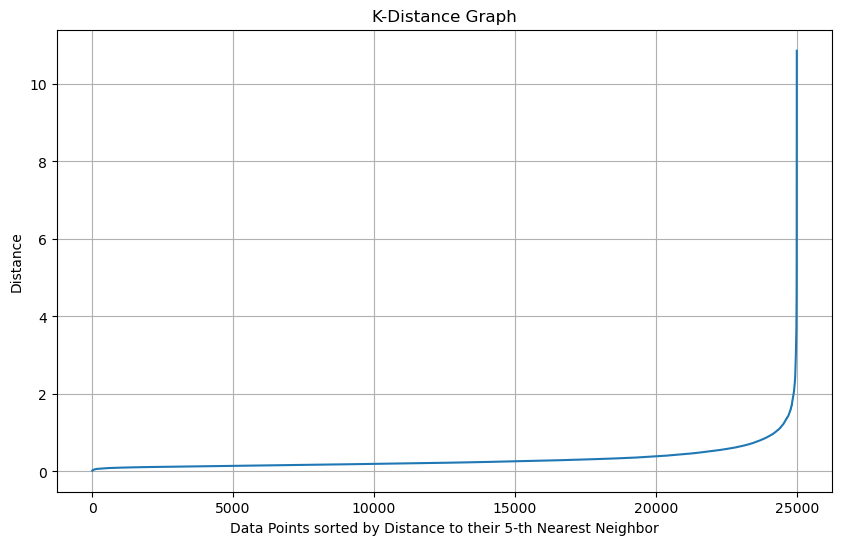

Anomalies found: 1784


/var/folders/j6/tvh87n0s6l12hjnnwjrp9mv00000gn/T/ipykernel_14605/181788210.py:136: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['opc_scheme'] = df['opc_scheme'].fillna(0)


In [8]:

# ####################### basic data definitions ######################
# #####################################################################
# # listing_id          - the unique id for the listing of a used car OK
# # title               - title of the listing; free text attribute typically containing the make, model, engine type/size
# # make                - make/brand of the car OK
# # model               - model of the car (for the given make/brand) NOT SURE
# # description         - title of the listing; free text attribute NOT SURE
# # manufactured        - Year the car was manufactured OK
# # original_reg_date   - Original registration data; date format string 
# # reg_date            - Registration data; date format string
# # type_of_vehicle     - Type of vehicle (e.g., "sports car", "luxury sedan")
# # category            - Category of the car; list of categories, comma-separated
# # transmission        - Type of transmission ("auto" or "manual")
# # curb_weight         - Weight in kg of the vehicle without any passenger or items
# # power               - Power of engine in kW
# # fuel_type           - Fuel type (e.g, "petrol", "diesel", "electric")
# # engine_cap          - Displacement of engine in cc (cubic centimeter)
# # no_of_owners        - Number of previous owners (>=1 since all cars are used)
# # depreciation        - Annual depreciation in SGD is the amount the owner loses on the value of the vehicle per year based on the assumption that the vehicle is deregistered only at the end of its 10-yr COE life-span
# # coe                 - Certificate of entitlement value in SGD when first registered
# # road_tax            - Road tax value in SGD calculated based on the engine capacity on a per annum basis
# # dereg_value         - deregistration value in SGD one will get back from the government upon deregistering the vehicle for use in Singapore
# # mileage             - Number of kilometers driven
# # omv                 - Open Market Value in SGD assessed by the Singapore Customs
# # arf                 - Additional Registration Fee in SGD is a tax imposed upon registration of a vehicle
# # opc_scheme          - Off-peak car scheme
# # lifespan            - Date stated on the lifespan marks the day that the vehicle must be deregistered
# # eco_category        - Eco category of vehicle
# # features            - Noteworthy features; free text attribute
# # accessories         - Noteworthy accessories ; free text attribute
# # indicative_price    - General guide to the price in SGD of the vehicle
# # price               - Resale price in SGD of the car

train_df = model_preprocessing(input_df = train_df_RAW, test=False)
train_df_base, train_df_eval = train_test_split(train_df, test_size=0.2, random_state=888888)
test_df = model_preprocessing(input_df = test_df_RAW, test=True)

In [12]:
# train_df.to_csv('../dataset/train_processed.csv')
# test_df.to_csv('../dataset/test_processed.csv')
name = "remove-outliers-fill-fuel-type"
train_df.to_csv(f'../dataset/train_processed_{name}.csv')
train_df.to_csv(f'../dataset/test_processed-{name}.csv')
train_df_base, train_df_eval = train_test_split(train_df, test_size=0.2, random_state=888888)

In [17]:
# Define the hyperparameter distributions
param_dist = {
            'learning_rate'     : stats.uniform(0.01, 0.1),
            'gamma'             : stats.uniform(0.01, 0.9),    
            'alpha'             : stats.uniform(0.01, 0.1),     
            
            'subsample'         : stats.uniform(0.3, 0.7),
            'colsample_bytree'  : stats.uniform(0.3, 0.7),
            'early_stopping_rounds' : stats.randint(8, 18), 
            'min_child_weight'  : stats.randint(3, 88),   
            }

model = xgboost.XGBRegressor(random_state = 888888, 
                                    n_estimators = 1888,
                                    max_depth    = 5,
                                    n_jobs       = -1, )


In [19]:

# # # Save the dictionary to a .json file
# with open('../result_dict.json', 'w') as file:
#     json.dump(results, file)

# print("Dictionary saved to result_dict.json")

# To load the dictionary back
with open('../result_dict.json', 'r') as file:
    results = json.load(file)

print("Loaded dictionary:", results)



Loaded dictionary: {'encoded-no-outliers-v1': {'params': {'alpha': 0.03170053864996126, 'colsample_bytree': 0.9234846177641767, 'early_stopping_rounds': 12, 'gamma': 0.19098598186699345, 'learning_rate': 0.09135624516842604, 'min_child_weight': 10, 'subsample': 0.6074058327882652}, 'model': 'encoded-no-outliers-v1.pkl', 'objfunc': -17157.992073074056, 'mean_test_score': -17654.25881042802, 'std_test_score': 1918.7154800514006, 'final_eval_rmse': 18459.371794654424}}


In [20]:
def train_evaluate(name: str, param_dist: dict, model, X, y, X_eval, y_eval, X_test, results: dict, save_model: bool = True, save_submission: bool = True):
    ####################### hyperparameters tuning ######################
    #####################################################################

    # Create the RandomizedSearchCV object
    random_search = RandomizedSearchCV(model, 
                                    param_distributions  = param_dist, 
                                    n_iter               = 88, 
                                    cv                   = 5, 
                                    random_state         = 888888,
                                    scoring              = 'neg_root_mean_squared_error', 
                                    )

    # Fit the RandomizedSearchCV object to the training data
    random_search.fit(X=X, y=y,
                    eval_set=[(X_eval, y_eval,)], verbose = False)
    random_search_df = pd.DataFrame(random_search.cv_results_)
    random_search_df = random_search_df[[ 'params',
                                        'split0_test_score',
                                        'split1_test_score',
                                        'split2_test_score',
                                        'split3_test_score',
                                        'split4_test_score',
                                        'mean_test_score',
                                        'std_test_score',
                                        'rank_test_score']]

    random_search_df['objfunc'] = random_search_df[['split0_test_score',
                                                    'split1_test_score',
                                                    'split2_test_score',
                                                    'split3_test_score',
                                                    'split4_test_score',]].median(axis=1)
    random_search_df = random_search_df.sort_values('objfunc', ascending = False)

    ####################### model training (USING ENCODED FEATURES) ######################
    #############################################################

    best_params = random_search_df['params'].iloc[0]
    # best_params = random_search.best_params_
    print(f"Best Parameters: {best_params}")

    best_model = model.__class__(**best_params)

    best_model.fit(X, y)

    eval_rmse = mean_squared_error(y_eval, best_model.predict(X_eval), squared=False)
    print(f"FINAL EVAL RMSE SCORE: {eval_rmse}")

    results[name] = {
        "params": random_search_df['params'].iloc[0],
        "model": f"{name}.pkl",
        "objfunc": random_search_df['objfunc'].iloc[0],
        "mean_test_score": random_search_df['mean_test_score'].iloc[0],
        "std_test_score": random_search_df['std_test_score'].iloc[0],
        "final_eval_rmse": eval_rmse
    }
    # Save the dictionary to a .json file
    with open('../result_dict.json', 'w') as file:
        json.dump(results, file)

    print("Dictionary saved to result_dict.json")

    if save_submission:
        submission_df = pd.DataFrame(best_model.predict(X_test)).reset_index().rename(columns = {'index':"Id", 0:'Predicted'})
        submission_df['Predicted'] = round(submission_df['Predicted'])
        submission_df.to_csv(f"../dataset/submission-{name}.csv", index = False)
    
    if save_model:
        with open(f'../models/{name}.pkl', 'wb') as file:
            pickle.dump(best_model, file)

        print(f"Model saved to '../models/{name}.pkl'")

    return best_model, best_params, random_search_df, submission_df, results


In [21]:
best_model, best_params, random_search_df, submission_df, results = train_evaluate(name=name,
                                                                                   param_dist=param_dist,
                                                                                   model=model,
                                                                                   X=train_df_base[ENCODED_feature_list],
                                                                                   y=train_df_base[target],
                                                                                   X_eval=train_df_eval[ENCODED_feature_list],
                                                                                   y_eval=train_df_eval[target],
                                                                                   X_test=test_df[ENCODED_feature_list],
                                                                                   results=results,
                                                                                   save_model=True,
                                                                                   save_submission=True,
                                                                                   )

KeyboardInterrupt: 

In [ ]:
####################### hyperparameters tuning ######################
#####################################################################

# Define the hyperparameter distributions
param_dist = {
            'learning_rate'     : stats.uniform(0.01, 0.1),
            'gamma'             : stats.uniform(0.01, 0.9),    
            'alpha'             : stats.uniform(0.01, 0.1),     
            
            'subsample'         : stats.uniform(0.3, 0.7),
            'colsample_bytree'  : stats.uniform(0.3, 0.7),
            'early_stopping_rounds' : stats.randint(8, 18), 
            'min_child_weight'  : stats.randint(3, 88),   
            }

xgb_model = xgboost.XGBRegressor(random_state = 888888, 
                                 n_estimators = 1888,
                                 max_depth    = 5,
                                 n_jobs       = -1, )

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_model, 
                                   param_distributions  = param_dist, 
                                   n_iter               = 88, 
                                   cv                   = 5, 
                                   random_state         = 888888,
                                   scoring              = 'neg_root_mean_squared_error', 
                                  )

# Fit the RandomizedSearchCV object to the training data
random_search.fit(train_df_base[ENCODED_feature_list], train_df_base[target],
                 eval_set=[(train_df_eval[ENCODED_feature_list], train_df_eval[target],)], verbose = False)
ENCODED_random_search_df = pd.DataFrame(random_search.cv_results_)
ENCODED_random_search_df = ENCODED_random_search_df[[ 'params',
                                     'split0_test_score',
                                     'split1_test_score',
                                     'split2_test_score',
                                     'split3_test_score',
                                     'split4_test_score',
                                     'mean_test_score',
                                     'std_test_score',
                                     'rank_test_score']]

ENCODED_random_search_df['objfunc'] = ENCODED_random_search_df[['split0_test_score',
                                                'split1_test_score',
                                                'split2_test_score',
                                                'split3_test_score',
                                                'split4_test_score',]].median(axis=1)
ENCODED_random_search_df = ENCODED_random_search_df.sort_values('objfunc', ascending = False)
ENCODED_random_search_df

In [ ]:
####################### hyperparameters tuning ######################
#####################################################################

# Define the hyperparameter distributions
param_dist = {
            'learning_rate'     : stats.uniform(0.01, 0.1),
            'gamma'             : stats.uniform(0.01, 0.9),    
            'alpha'             : stats.uniform(0.01, 0.1),     
            
            'subsample'         : stats.uniform(0.3, 0.7),
            'colsample_bytree'  : stats.uniform(0.3, 0.7),
            'early_stopping_rounds' : stats.randint(8, 18), 
            'min_child_weight'  : stats.randint(3, 88),   
            }

xgb_model = xgboost.XGBRegressor(random_state = 888888, 
                                 n_estimators = 1888,
                                 max_depth    = 5,
                                 n_jobs       = -1, )

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_model, 
                                   param_distributions  = param_dist, 
                                   n_iter               = 88, 
                                   cv                   = 5, 
                                   random_state         = 888888,
                                   scoring              = 'neg_root_mean_squared_error', 
                                  )

# Fit the RandomizedSearchCV object to the training data
random_search.fit(train_df_base[ENCODED_feature_list], train_df_base[target],
                 eval_set=[(train_df_eval[ENCODED_feature_list], train_df_eval[target],)], verbose = False)
ENCODED_random_search_df = pd.DataFrame(random_search.cv_results_)
ENCODED_random_search_df = ENCODED_random_search_df[[ 'params',
                                     'split0_test_score',
                                     'split1_test_score',
                                     'split2_test_score',
                                     'split3_test_score',
                                     'split4_test_score',
                                     'mean_test_score',
                                     'std_test_score',
                                     'rank_test_score']]

ENCODED_random_search_df['objfunc'] = ENCODED_random_search_df[['split0_test_score',
                                                'split1_test_score',
                                                'split2_test_score',
                                                'split3_test_score',
                                                'split4_test_score',]].median(axis=1)
ENCODED_random_search_df = ENCODED_random_search_df.sort_values('objfunc', ascending = False)
ENCODED_random_search_df

In [19]:
####################### model training (USING ENCODED FEATURES) ######################
#############################################################

best_params = ENCODED_random_search_df['params'].iloc[0]

ENCODED_xbg_model = xgboost.XGBRegressor(random_state           = 888888,
                                         n_estimators           = 1888,
                                         n_jobs                 = -1,
                                         max_depth              = 5,
                                         early_stopping_rounds  = best_params['early_stopping_rounds'],
                                         
                                         learning_rate          = best_params['learning_rate'], #  step size shrinkage used in updates to prevent overfitting. Lower values make the model more robust by taking smaller steps.
                                         gamma                  = best_params['gamma'], #minimum loss reduction required to make a further partition on a leaf node of the tree. Higher values increase the regularization.
                                         alpha                  = best_params['alpha'], #L2 regularization term on weights. 
                                         
                                         subsample              = best_params['subsample'], #percentage of rows used for each tree construction. 
                                         colsample_bytree       = best_params['colsample_bytree'], #percentage of columns used for each tree construction
                                         min_child_weight       = best_params['min_child_weight'], #Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning.
                                         verbosity = 2)

ENCODED_xbg_model.fit(train_df_base[ENCODED_feature_list], train_df_base[target],
                      eval_set=[(train_df_eval[ENCODED_feature_list], train_df_eval[target],)], verbose = False)
eval_rmse = mean_squared_error(train_df_eval[target], ENCODED_xbg_model.predict(train_df_eval[ENCODED_feature_list]), squared=False)
print(f"FINAL EVAL RMSE SCORE: {eval_rmse}")

submission_df = pd.DataFrame(ENCODED_xbg_model.predict(test_df[ENCODED_feature_list])).reset_index().rename(columns = {'index':"Id", 0:'Predicted'})
submission_df['Predicted'] = round(submission_df['Predicted'])
submission_df.to_csv(r"../dataset/submission-no-outliers.csv", index = False)

FINAL EVAL RMSE SCORE: 18459.371794654424


/Users/cheah/opt/anaconda3/envs/cs5228-project/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [21]:
import pickle
with open('../models/encoded-no-outliers-v1.pkl', 'wb') as file:
    pickle.dump(ENCODED_xbg_model, file)

print("Model saved to model.pkl")

Model saved to model.pkl


In [22]:
ENCODED_random_search_df.head(2)

,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,objfunc
80,"{'alpha': 0.03170053864996126, 'colsample_bytr...",-16997.247474,-17157.992073,-20744.722846,-18460.783885,-14910.547775,-17654.258810,1918.715480,16,-17157.992073
4,"{'alpha': 0.09341722710073318, 'colsample_bytr...",-17190.784805,-17275.368240,-19062.953440,-17249.915179,-13530.404720,-16861.885277,1809.595205,1,-17249.915179


In [26]:
results = {
    "encoded-no-outliers-v1": {
        "params": ENCODED_random_search_df['params'].iloc[0],
        "model": "encoded-no-outliers-v1.pkl",
        "objfunc": ENCODED_random_search_df['objfunc'].iloc[0],
        "mean_test_score": ENCODED_random_search_df['mean_test_score'].iloc[0],
        "std_test_score": ENCODED_random_search_df['std_test_score'].iloc[0],
        "final_eval_rmse": eval_rmse
    }
}

In [19]:
####################### hyperparameters tuning ######################
#####################################################################

# Define the hyperparameter distributions
param_dist = {
            'learning_rate'     : stats.uniform(0.01, 0.1),
            'gamma'             : stats.uniform(0.01, 0.9),    
            'alpha'             : stats.uniform(0.01, 0.1),     
            
            'subsample'         : stats.uniform(0.3, 0.7),
            'colsample_bytree'  : stats.uniform(0.3, 0.7),
            'early_stopping_rounds' : stats.randint(8, 18), 
            'min_child_weight'  : stats.randint(3, 88),   
            }

xgb_model = xgboost.XGBRegressor(random_state = 888888, 
                                 n_estimators = 1888,
                                 max_depth    = 5,              
                                 enable_categorical    = True,
                                 n_jobs = -1)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_model, 
                                   param_distributions  = param_dist, 
                                   n_iter               = 88, 
                                   cv                   = 5, 
                                   random_state         = 888888,
                                   scoring              = 'neg_root_mean_squared_error',)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(train_df_base[CAT_feature_list], train_df_base[target],
                  eval_set=[(train_df_eval[CAT_feature_list], train_df_eval[target],)], verbose = False)
CAT_random_search_df = pd.DataFrame(random_search.cv_results_)
CAT_random_search_df = CAT_random_search_df[['params',
                                     'split0_test_score',
                                     'split1_test_score',
                                     'split2_test_score',
                                     'split3_test_score',
                                     'split4_test_score',
                                     'mean_test_score',
                                     'std_test_score',
                                     'rank_test_score']]

CAT_random_search_df['objfunc'] = CAT_random_search_df[['split0_test_score',
                                                'split1_test_score',
                                                'split2_test_score',
                                                'split3_test_score',
                                                'split4_test_score',]].median(axis=1)
CAT_random_search_df = CAT_random_search_df.sort_values('objfunc', ascending = False)


In [20]:
####################### model training (USING CAT FEATURES) ######################
#############################################################

best_params = CAT_random_search_df['params'].iloc[0]


CAT_xbg_model = xgboost.XGBRegressor(random_state           = 888888,
                                     n_estimators           = 1888,
                                     enable_categorical     = True,
                                     n_jobs                 = -1,
                                     max_depth              = 5,
                                     early_stopping_rounds  = best_params['early_stopping_rounds'],
                                     
                                     learning_rate          = best_params['learning_rate'], #  step size shrinkage used in updates to prevent overfitting. Lower values make the model more robust by taking smaller steps.
                                     gamma                  = best_params['gamma'], #minimum loss reduction required to make a further partition on a leaf node of the tree. Higher values increase the regularization.
                                     alpha                  = best_params['alpha'], #L2 regularization term on weights. 
                                     
                                     subsample              = best_params['subsample'], #percentage of rows used for each tree construction. 
                                     colsample_bytree       = best_params['colsample_bytree'], #percentage of columns used for each tree construction
                                     min_child_weight       = best_params['min_child_weight'], #Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning.
                                     verbosity = 2)

CAT_xbg_model.fit(train_df_base[CAT_feature_list], train_df_base[target],
                      eval_set=[(train_df_eval[CAT_feature_list], train_df_eval[target],)], verbose = False)

eval_rmse = mean_squared_error(train_df_eval[target], CAT_xbg_model.predict(train_df_eval[CAT_feature_list]), squared=False)
print(f"FINAL EVAL RMSE SCORE: {eval_rmse}")

submission_df = pd.DataFrame(CAT_xbg_model.predict(test_df[CAT_feature_list])).reset_index().rename(columns = {'index':"Id", 0:'Predicted'})
submission_df['Predicted'] = round(submission_df['Predicted'])
submission_df.to_csv(r"./data/submission.csv", index = False)

FINAL EVAL RMSE SCORE: 25524.914110039103


In [ ]:
CAT_importance = pd.Series(CAT_xbg_model.feature_importances_, index = CAT_xbg_model.feature_names_in_).reset_index()
CAT_importance = CAT_importance.sort_values(0, ascending = False).reset_index(drop=True)
CAT_importance.head(50)